In [2]:
# === Dipendenze ===
import warnings
warnings.filterwarnings("ignore")

import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
import osmnx as ox
import pandas as pd

try:
    import contextily as ctx
    HAS_CTX = True
except Exception:
    HAS_CTX = False

ox.settings.use_cache = True
ox.settings.log_console = False
ox.settings.timeout = 180

# === Parametri ===
PARAMS = {
    "center_latlon": (41.940583, 12.418912),  # Santa Maria della Pietà
    "dist_m": 5000,                           # raggio in metri
    "crs_metric": "EPSG:32633",               # UTM 33N
    "use_basemap": True,                      # usa basemap CartoDB se contextily disponibile
}

In [3]:


# === AOI: buffer metrico attorno al punto ===
lat, lon = PARAMS["center_latlon"]
gdf_pt = gpd.GeoDataFrame(geometry=[Point(lon, lat)], crs=4326)
aoi_m = gdf_pt.to_crs(PARAMS["crs_metric"]).buffer(PARAMS["dist_m"])
aoi = aoi_m.to_crs(4326).iloc[0]                   # polygon in WGS84 per query
aoi_gdf = gpd.GeoDataFrame(geometry=[aoi], crs=4326)

# === EDIFICI (solo poligoni) ===
building_tags = {"building": True}

if hasattr(ox, "features_from_polygon"):
    buildings = ox.features_from_polygon(aoi, tags=building_tags)
else:
    buildings = ox.geometries_from_polygon(aoi, tags=building_tags)

# Filtro e proiezione
buildings = buildings[buildings.geometry.type.isin(["Polygon", "MultiPolygon"])].copy()
buildings = gpd.clip(buildings, aoi_gdf)
buildings3857 = buildings.to_crs(3857)


# === Tag “verde” da OSM ===
tags = {
    "leisure": [
        "park", "garden", "recreation_ground", "nature_reserve",
        "golf_course", "dog_park", "playground", "pitch"    ],
    "landuse": [
        "grass", "forest", "recreation_ground", "meadow",
        "orchard", "vineyard", "cemetery", "farmland", "flowerbed",
        "greenfield", "allotments", "reservoir", "basin",
        "greenhouse_horticulture", "farmyard"  # NEW
    ],
    "natural": [
        "wood", "grassland", "heath", "scrub", "wetland", "water",
        "tree_row", "shrub"  # NEW
    ],
    "man_made": [
        "flowerbed", "planter"  # NEW (alcuni planters sono grandi, e possono contenere verde urbano)
    ],
    "barrier": [
        "hedge"  # siepi
    ],
    "surface": [
        "grass", "sand", "tartan", "ground", "dirt"  # NEW – superfici verdi o da parco giochi
    ]
}

# === Download geometrie OSM (compat v1/v2) ===
if hasattr(ox, "features_from_polygon"):          # OSMnx v2.x
    gdf = ox.features_from_polygon(aoi, tags=tags)
else:                                             # OSMnx v1.x
    gdf = ox.geometries_from_polygon(aoi, tags=tags)

# Tieni solo poligoni
gdf = gdf[gdf.geometry.type.isin(["Polygon", "MultiPolygon"])].copy()
# Clip all'AOI
gdf = gpd.clip(gdf, aoi_gdf)

# Categoria (macro-chiave)
def pick_cat(row):
    for c in ["leisure", "landuse", "natural"]:
        v = row.get(c)
        if isinstance(v, str) and v:
            return f"{c}:{v}"
    return "other"

gdf["category"] = gdf.apply(pick_cat, axis=1)

# === Plot (Web Mercator per basemap) ===
gdf3857 = gdf.to_crs(3857)
aoi3857 = aoi_gdf.to_crs(3857)

# --- ACQUE: poligoni e linee (OSM) ---
water_tags_poly = {
    "natural": ["water", "wetland"],
    "landuse": ["reservoir", "basin"],
    "water": ["lake", "pond", "reservoir", "river", "canal"]
}
water_tags_line = {
    "waterway": ["river", "stream", "canal", "ditch", "drain"]
}

# Poligoni d'acqua
if hasattr(ox, "features_from_polygon"):
    water_poly = ox.features_from_polygon(aoi, tags=water_tags_poly)
else:
    water_poly = ox.geometries_from_polygon(aoi, tags=water_tags_poly)

# Tieni solo poligoni/multipoligoni e clippa
water_poly = water_poly[water_poly.geometry.type.isin(["Polygon", "MultiPolygon"])].copy()
water_poly = gpd.clip(water_poly, aoi_gdf)
water_poly3857 = water_poly.to_crs(3857)

# Linee d'acqua
if hasattr(ox, "features_from_polygon"):
    water_line = ox.features_from_polygon(aoi, tags=water_tags_line)
else:
    water_line = ox.geometries_from_polygon(aoi, tags=water_tags_line)

# Tieni solo LineString/MultiLineString e clippa
water_line = water_line[water_line.geometry.type.isin(["LineString", "MultiLineString"])].copy()
water_line = gpd.clip(water_line, aoi_gdf)
water_line3857 = water_line.to_crs(3857)

# --- FILTRO: tieni solo corsi d'acqua visibili (fiumi e canali, non sotterranei) ---
if "waterway" in water_line.columns:
    def is_visible_water(row):
        tipo = str(row.get("waterway", ""))
        tunnel = str(row.get("tunnel", ""))
        layer = str(row.get("layer", ""))
        return (tipo in ["river", "canal"]) and (tunnel != "yes") and (layer not in ["-1", "-2"])
    
    water_line_visible = water_line[water_line.apply(is_visible_water, axis=1)].copy()
    water_line3857 = water_line_visible.to_crs(3857)
else:
    # fallback: se manca la colonna, lascio tutto
    water_line_visible = water_line


# Stili acqua
WATER_FILL = "#4aa3df"   # azzurro poligoni
WATER_EDGE = "#2c7fb8"   # bordo poligoni
WATER_LINE = "#2c7fb8"   # linee fiumi/rogge

# --- Opzioni layer leggeri ---
SHOW_ROADS = True
SHOW_LANDUSE_OUTLINES = True      # contorni sottili e tratteggiati
SHOW_LANDUSE_CENTROIDS = False    # alternative: puntini ai centroidi

# --- STRADE (rete "drive" nell'AOI) ---
edges_major3857 = gpd.GeoDataFrame(geometry=[], crs=3857)
edges_minor3857 = gpd.GeoDataFrame(geometry=[], crs=3857)

try:
    G = ox.graph_from_polygon(aoi, network_type="drive", simplify=True)
    edges = ox.graph_to_gdfs(G, nodes=False, edges=True)

    # Classifica le strade
    MAJOR_BASE = {"motorway", "trunk", "primary", "secondary", "tertiary"}

    def normalize_highway(hw):
        if hw is None or (isinstance(hw, float) and pd.isna(hw)):
            return []
        if isinstance(hw, (list, set, tuple)):
            vals = list(hw)
        else:
            vals = [hw]
        cleaned = []
        for v in vals:
            s = str(v).lower().strip()
            if s.endswith("_link"):
                s = s[:-5]
            cleaned.append(s)
        return cleaned

    def classify_road(hw):
        base_vals = normalize_highway(hw)
        return "major" if any(b in MAJOR_BASE for b in base_vals) else "minor"

    # Applica classificazione e conversione CRS
    edges["road_class"] = edges["highway"].apply(classify_road)
    edges3857 = edges.to_crs(3857)
    edges_major3857 = edges3857[edges3857["road_class"] == "major"].copy()
    edges_minor3857 = edges3857[edges3857["road_class"] == "minor"].copy()

except Exception as e:
    print("Errore durante il caricamento delle strade:", e)

# Rendi disponibili per il plot
globals()["edges_major3857"] = edges_major3857
globals()["edges_minor3857"] = edges_minor3857

# --- LANDUSE: contorni/centroidi leggeri ---
landuse_gdf = gdf.loc[gdf["landuse"].notna()].copy()
landuse3857 = landuse_gdf.to_crs(3857)
landuse_centroids3857 = landuse3857.copy()
landuse_centroids3857["geometry"] = landuse_centroids3857.geometry.centroid


palette = {
    "leisure":  "#6FD08C",  # verde chiaro
    "landuse":  "#A3D977",  # verde giallognolo
    "natural":  "#4DAA57",  # verde scuro
    "other":    "#BFDDBF",  # grigio-verde chiaro
}

def top_key(cat): return cat.split(":")[0] if isinstance(cat, str) and ":" in cat else "other"
colors = gdf3857["category"].apply(lambda c: palette.get(top_key(c), palette["other"]))



In [4]:
from shapely.ops import linemerge, unary_union

def unisci_segmenti(gdf):
    if gdf.empty:
        return gpd.GeoDataFrame(geometry=[], crs=gdf.crs)

    # Unisci tutte le geometrie in un'unica MultiLineString e poi fondi le connessioni
    merged = linemerge(unary_union(gdf.geometry))
    
    # Se il risultato è una singola LineString, lo mettiamo in una lista
    if merged.geom_type == "LineString":
        geometries = [merged]
    else:
        geometries = list(merged.geoms)

    return gpd.GeoDataFrame(geometry=geometries, crs=gdf.crs)

# Crea versioni "fuse" per il test o il plot
edges_major_fused = unisci_segmenti(edges_major3857)
edges_minor_fused = unisci_segmenti(edges_minor3857)

# fig, ax = plt.subplots(figsize=(10, 10))
# edges_minor_fused.plot(ax=ax, color="#90a4ae", linewidth=0.6, alpha=0.5)
# edges_major_fused.plot(ax=ax, color="#e65100", linewidth=2.5)
# plt.title("Strade fuse (continuità migliorata)")
# plt.axis("off")
# plt.show()



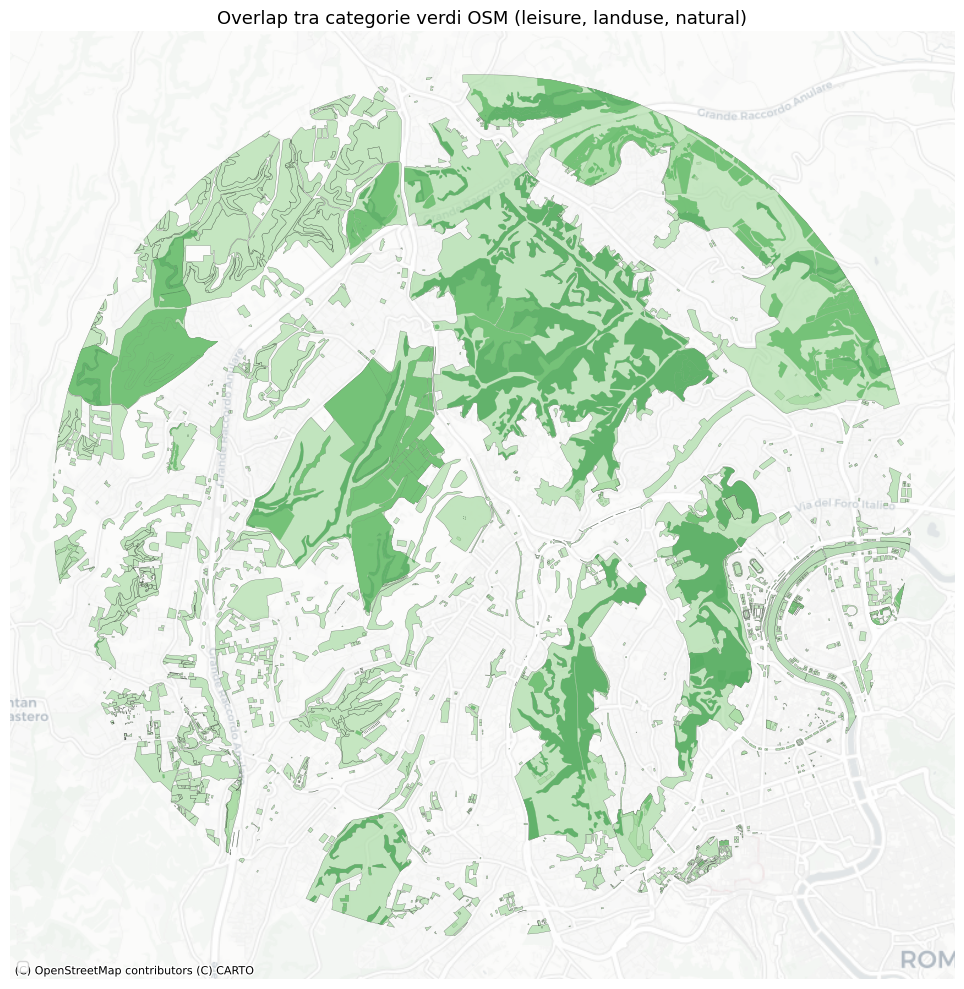

In [5]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import contextily as ctx

# --- Assumiamo che esista gdf3857 (OSM verde proiettato in EPSG:3857) ---

# 1️⃣ Seleziona solo categorie verdi principali
verde = gdf3857[gdf3857["category"].str.startswith(("leisure:", "landuse:", "natural:"))].copy()

# 2️⃣ Suddividi per gruppo principale
leisure = verde[verde["category"].str.startswith("leisure")].copy()
landuse = verde[verde["category"].str.startswith("landuse")].copy()
natural = verde[verde["category"].str.startswith("natural")].copy()

# 3️⃣ Intersezioni tra categorie
overlap_ll = gpd.overlay(leisure, landuse, how="intersection")
overlap_ln = gpd.overlay(leisure, natural, how="intersection")

# Aggiungi etichetta combo per colore
overlap_ln["combo"] = "leisure+natural"
overlap_ll["combo"] = "leisure+landuse"

# 4️⃣ Unisci in un unico DataFrame
verde_overlap = pd.concat([overlap_ll, overlap_ln], ignore_index=True)

# 5️⃣ Palette personalizzata
palette_overlap = {
    "leisure+landuse": "#6FBF73",  # verde intermedio
    "leisure+natural": "#5AAE65"
}

# ===============================================
# 6️⃣ PLOT COMPLETO (aggiungiamo ax e basemap)
# ===============================================
fig, ax = plt.subplots(figsize=(10, 10))

# --- Base: tutte le aree verdi OSM ---
verde.plot(ax=ax, color="#a1d99b", edgecolor="k", linewidth=0.2, alpha=0.6, label="Verde OSM")

# --- Aree di overlap ---
if not verde_overlap.empty:
    verde_overlap.plot(
        ax=ax,
        color=verde_overlap["combo"].map(palette_overlap),
        edgecolor=None,
        alpha=0.9,
        zorder=12,
        label="Overlap categorie verdi"
    )

# --- Basemap ---
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, alpha=0.7)
ax.set_title("Overlap tra categorie verdi OSM (leisure, landuse, natural)", fontsize=13)
ax.legend(loc="lower left", frameon=True)
ax.set_axis_off()
plt.tight_layout()
plt.show()


In [6]:
import itertools

# --- Filtra solo le categorie verdi ---
verde = gdf3857[gdf3857["category"].str.startswith(("leisure:", "landuse:", "natural:"))].copy()

# Suddividi per gruppo principale
categorie = {
    "leisure": verde[verde["category"].str.startswith("leisure")].copy(),
    "landuse": verde[verde["category"].str.startswith("landuse")].copy(),
    "natural": verde[verde["category"].str.startswith("natural")].copy()
}

# Trova tutte le combinazioni di 2 o più categorie
overlap_counts = []

for n in [2, 3]:
    for combo in itertools.combinations(categorie.keys(), n):
        gdf_int = categorie[combo[0]]
        for c in combo[1:]:
            gdf_int = gpd.overlay(gdf_int, categorie[c], how="intersection")
        if not gdf_int.empty:
            overlap_counts.append((combo, len(gdf_int)))

# Stampa risultati
if overlap_counts:
    print("Overlaps trovati:")
    for combo, count in overlap_counts:
        print(f"{' + '.join(combo):<30} → {count} aree")
else:
    print("Nessun overlap rilevato tra categorie verdi.")


Overlaps trovati:
leisure + landuse              → 275 aree
leisure + natural              → 200 aree
landuse + natural              → 23 aree
leisure + landuse + natural    → 2 aree


In [7]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
from shapely.geometry import Point
from matplotlib.patches import Patch
import matplotlib_scalebar.scalebar as sb

# ================================================================
# 🟩 BLOCCO PRE-PLOT – costruzione layer "verde" e "overlap" pulita
# ================================================================

# 1️⃣ Seleziona solo categorie verdi principali (leisure, landuse, natural)
verde = gdf3857[gdf3857["category"].str.startswith(("leisure:", "landuse:", "natural:"))].copy()

# 2️⃣ Suddividi per gruppo principale
leisure = verde[verde["category"].str.startswith("leisure")].copy()
landuse = verde[verde["category"].str.startswith("landuse")].copy()
natural = verde[verde["category"].str.startswith("natural")].copy()

# 3️⃣ Calcola intersezioni (overlap) tra coppie di categorie principali
overlap_ll = gpd.overlay(leisure, landuse, how="intersection")
overlap_ln = gpd.overlay(leisure, natural, how="intersection")
overlap_ln["source"] = "leisure+natural"
overlap_ll["source"] = "leisure+landuse"

# 4️⃣ Unisci e dissolvi gli overlap
verde_overlap = pd.concat([overlap_ll, overlap_ln], ignore_index=True)
if not verde_overlap.empty:
    verde_overlap["grp"] = 1
    verde_overlap = verde_overlap.dissolve(by="grp").explode(index_parts=False)
else:
    verde_overlap = gpd.GeoDataFrame(geometry=[], crs=verde.crs)

# 5️⃣ Palette e colori uniformi
palette = {
    "leisure":  "#6FD08C",  # verde chiaro
    "landuse":  "#A3D977",  # verde giallognolo
    "natural":  "#4DAA57",  # verde scuro
}
COLOR_OVERLAP = "#b3e5c8"   # unico colore per tutte le aree di overlap

# 6️⃣ Funzione per colorare i poligoni base
def get_color(cat):
    if not isinstance(cat, str):
        return "#BFDDBF"
    if cat.startswith("leisure"):
        return palette["leisure"]
    elif cat.startswith("landuse"):
        return palette["landuse"]
    elif cat.startswith("natural"):
        return palette["natural"]
    return "#BFDDBF"

colors = verde["category"].apply(get_color)

# =========================
# Layer "non_verde" robusto
# =========================
def _fix_valid(gdf):
    g = gdf.copy()
    g["geometry"] = g.geometry.buffer(0)
    return g[g.geometry.notnull() & ~g.geometry.is_empty]

# 1) AOI come GeoDataFrame pulito
aoi_poly = gpd.GeoDataFrame(geometry=aoi3857.geometry.values, crs=aoi3857.crs)
aoi_poly = _fix_valid(aoi_poly)

# 2) Verde ritagliato sull'AOI e dissolto in una sola geometria
verde_clip = _fix_valid(gpd.clip(verde[["geometry"]], aoi_poly))
if verde_clip.empty:
    non_verde = aoi_poly.copy()
else:
    verde_diss = _fix_valid(verde_clip.dissolve())  # una riga (MultiPolygon)
    # 3) Differenza: AOI − Verde  → zone non classificate (vuoti)
    non_verde = gpd.overlay(
        aoi_poly[["geometry"]],
        verde_diss[["geometry"]],
        how="difference",
        keep_geom_type=True,
    )
    non_verde = _fix_valid(non_verde)


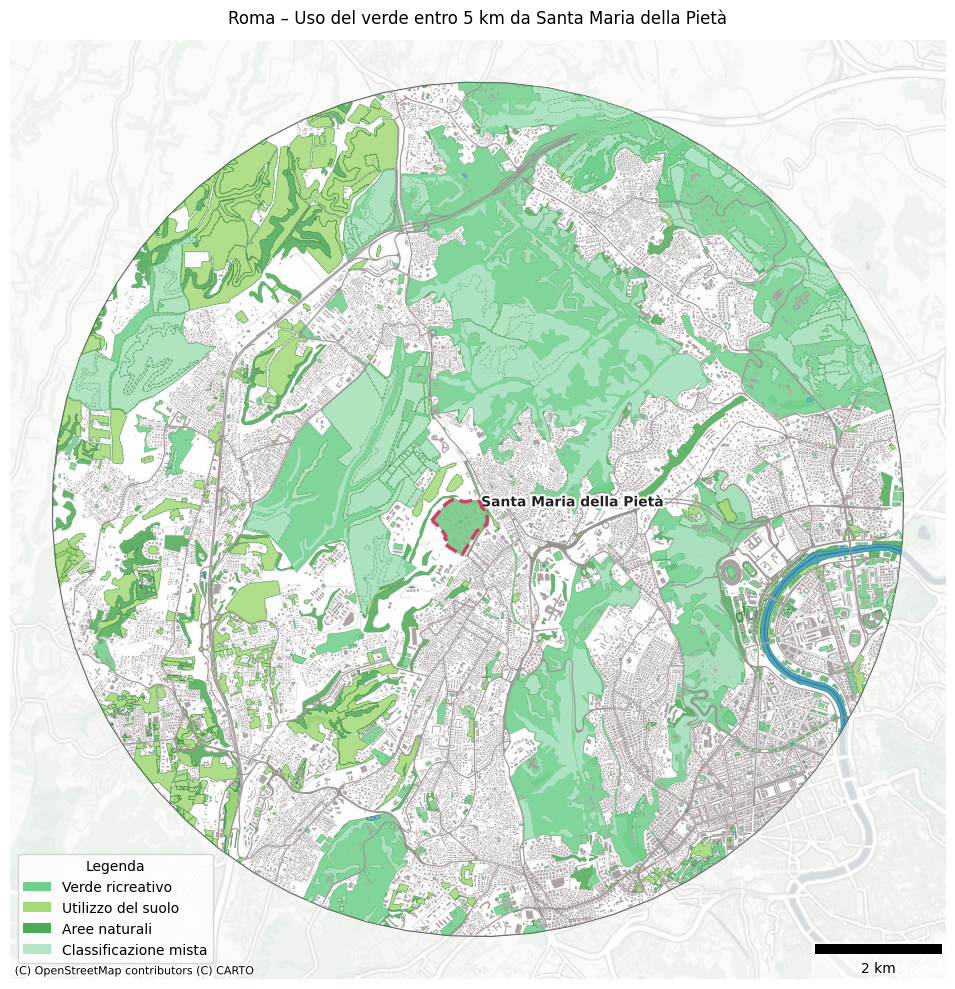

Creato file: mappa_verde_smdp.png


In [ ]:

# ================================================================
# 🗺️ PLOT MAPPA COMPLETA
# ================================================================

fig, ax = plt.subplots(figsize=(10,10))

# --- Vuoti dell'AOI (semitrasparenti, per far vedere la basemap) ---
if not non_verde.empty:
    non_verde.plot(
        ax=ax,
        facecolor="white",   # oppure "#f5f5f5"
        edgecolor="none",
        alpha=0.45,          # regola 0.3–0.6 a gusto
        zorder=2
    )


# --- AOI e verde ---
aoi3857.boundary.plot(ax=ax, color="#444444", linewidth=1.0)

# --- Layer "non verde" semitrasparente (lascia intravedere la basemap) ---
if not non_verde.empty:
    non_verde.plot(
        ax=ax,
        facecolor="white",  # o "#f5f5f5" se vuoi più caldo
        edgecolor="none",
        alpha=0.6,          # livello di trasparenza (0=trasp. totale, 1=opaco)
        zorder=2
    )

# Verde di base
verde.plot(ax=ax, color=colors, edgecolor="#4F8F59", linewidth=0.3, alpha=0.85, zorder=5)

# Overlap (unico colore)
if not verde_overlap.empty:
    verde_overlap.plot(ax=ax, color=COLOR_OVERLAP, edgecolor=None, alpha=0.9, zorder=6)

# --- Basemap ---
if PARAMS["use_basemap"] and HAS_CTX:
    try:
        ctx.add_basemap(
            ax, crs=gdf3857.crs,
            source=ctx.providers.CartoDB.PositronNoLabels,
            zorder=-10
        )
    except Exception:
        pass

# --- ACQUE ---
if not water_poly3857.empty:
    water_poly3857.plot(ax=ax, facecolor=WATER_FILL, edgecolor=WATER_EDGE,
                        linewidth=0.6, alpha=0.6, zorder=6)
if not water_line3857.empty:
    water_line3857.plot(ax=ax, color=WATER_LINE, linewidth=1.2, alpha=0.9, zorder=7)

# --- STRADE (senza legenda) ---
if SHOW_ROADS:
    COLOR_MAJOR = "#9C9090"
    COLOR_MINOR = "#bbbbbb"
    if not edges_minor_fused.empty:
        edges_minor_fused.plot(ax=ax, linewidth=0.6, alpha=0.5, color=COLOR_MINOR, zorder=30)
    if not edges_major_fused.empty:
        edges_major_fused.plot(ax=ax, linewidth=0.9, alpha=0.9, color=COLOR_MAJOR, zorder=31)

# --- LANDUSE ---
if SHOW_LANDUSE_OUTLINES and not landuse3857.empty:
    landuse3857.boundary.plot(ax=ax, linewidth=0.6, linestyle="--",
                              alpha=0.4, color="#2e7d32", zorder=8)
if SHOW_LANDUSE_CENTROIDS and not landuse_centroids3857.empty:
    ax.scatter(landuse_centroids3857.geometry.x, landuse_centroids3857.geometry.y,
               s=8, marker='o', color="#2e7d32", alpha=0.6, zorder=6)

# --- EDIFICI ---
if not buildings3857.empty:
    buildings3857.plot(ax=ax, color="#aaa0a0", edgecolor=None, linewidth=0.0,
                       alpha=0.95, zorder=50)

# --- LEGENDA ---
etichetta_italiana = {
    "leisure":  "Verde ricreativo",
    "landuse":  "Utilizzo del suolo",
    "natural":  "Aree naturali",
    "overlap":  "Classificazione mista"
}
handles = [
    Patch(facecolor=palette["leisure"], edgecolor="none", label=etichetta_italiana["leisure"]),
    Patch(facecolor=palette["landuse"], edgecolor="none", label=etichetta_italiana["landuse"]),
    Patch(facecolor=palette["natural"], edgecolor="none", label=etichetta_italiana["natural"]),
    Patch(facecolor=COLOR_OVERLAP, edgecolor="none", label=etichetta_italiana["overlap"])
]
ax.legend(handles=handles, loc="lower left", bbox_to_anchor=(0.001, 0.01), title="Legenda")

# --- Titolo e scalebar ---
ax.set_axis_off()
ax.set_title("Roma – Uso del verde entro 5 km da Santa Maria della Pietà", pad=12)
scalebar = sb.ScaleBar(1, units="m", dimension="si-length",
                       location="lower right", box_alpha=0.6)
ax.add_artist(scalebar)

# --- Marker Santa Maria della Pietà ---
point_3857 = gpd.GeoDataFrame(geometry=[Point(lon, lat)], crs=4326).to_crs(3857)
p = point_3857.geometry.iloc[0]
gdf_verde_hit = verde[verde.intersects(p)].copy()

if not gdf_verde_hit.empty:
    gdf_verde_hit.boundary.plot(ax=ax, color="#CE3F6A", linewidth=2.5,
                                linestyle="--", zorder=150)
    gdf_verde_hit.plot(ax=ax, color="#81C784", alpha=0.4, edgecolor=None, zorder=140)

for x, y in zip(point_3857.geometry.x, point_3857.geometry.y):
    ax.text(x + 50, y + 50, "Santa Maria della Pietà",
            fontsize=10, fontweight='bold', color='#222222',
            path_effects=[pe.withStroke(linewidth=3, foreground="white")],
            zorder=101)

plt.tight_layout()
# plt.savefig("mappa_verde_smdp.png", dpi=200, bbox_inches="tight")
plt.show()

print("Creato file: mappa_verde_smdp.png")


In [9]:
verde_nomi = verde[['name', 'geometry']].copy()
verde_nomi = verde_nomi[verde_nomi['name'].notna() & (verde_nomi['name'] != '')].reset_index(drop=True)

# Aggiunge un indice numerico progressivo a partire da 1
verde_nomi['id_area'] = range(1, len(verde_nomi) + 1)

verde_nomi

id_selezionati = [1, 14, 62, 67, 69, 129, 130, 30, 28]

aree_selezionate = verde_nomi[verde_nomi['id_area'].isin(id_selezionati)].copy()
# Rinumerazione progressiva da 1
aree_selezionate = aree_selezionate.reset_index(drop=True)
aree_selezionate['id_area'] = range(1, len(aree_selezionate) + 1)

# Controllo
aree_selezionate.head()

name  \
0  Riserva Naturale dell'Acquafredda   
1             Parco delle Campanelle   
2  Parco Agricolo di Casal del Marmo   
3               Cooperativa Cobragor   
4                   Pineta Sacchetti   

                                            geometry  id_area  
0  POLYGON ((1380118.475 5145782.81, 1380119.833 ...        1  
1  POLYGON ((1379927.484 5149915.194, 1379971.778...        2  
2  POLYGON ((1381151.486 5152189.218, 1381099.823...        3  
3  POLYGON ((1381457.27 5153039.698, 1381458.762 ...        4  
4  POLYGON ((1383243.77 5147505.291, 1383204.151 ...        5

In [10]:
import geopandas as gpd
from shapely.geometry import Point

def aggiungi_area_manual(gdf_aree, name, lon, lat):
    """
    Aggiunge manualmente una nuova riga al GeoDataFrame 'aree_selezionate',
    partendo da un nome e coordinate (lon, lat) in WGS84.
    
    🔹 gdf_aree : GeoDataFrame esistente (es. aree_selezionate)
    🔹 name     : stringa, nome dell'area da aggiungere
    🔹 lon, lat : coordinate in WGS84 (float)
    """
    # Crea la geometria nel CRS corretto (3857)
    nuovo_punto = gpd.GeoDataFrame(
        [{'name': name}],
        geometry=[Point(lon, lat)],
        crs=4326
    ).to_crs(3857)

    # Mantieni solo le colonne necessarie
    nuovo_punto = nuovo_punto[['name', 'geometry']]

    # Aggiungi al GeoDataFrame esistente
    gdf_aree = pd.concat([gdf_aree, nuovo_punto], ignore_index=True)

    # Rinumera id_area
    gdf_aree['id_area'] = range(1, len(gdf_aree) + 1)

    return gdf_aree

# aree_selezionate = aggiungi_area_manual(
#     aree_selezionate,
#     name="Agriturismo Cobgragor",
#     lon=12.410472496117185,
#     lat=41.947141090042116
# )

aree_selezionate = aggiungi_area_manual(
    aree_selezionate,
    name="Fosso Campanelle",
    lon=12.41546967323274,
    lat=41.94527468063234
)

aree_selezionate.tail()


name  \
5  Parco Regionale Urbano del Pineto   
6    Riserva Naturale di Monte Mario   
7           Macchia di Acquatraversa   
8  Riserva Naturale dell'Insugherata   
9                   Fosso Campanelle   

                                            geometry  id_area  
5  POLYGON ((1383492.346 5149743.401, 1383493.671...        6  
6  MULTIPOLYGON (((1384825.887 5147313.018, 13848...        7  
7  POLYGON ((1385464.727 5153855.617, 1385455.176...        8  
8  MULTIPOLYGON (((1384200.227 5152611.71, 138424...        9  
9                    POINT (1382083.762 5152785.378)       10

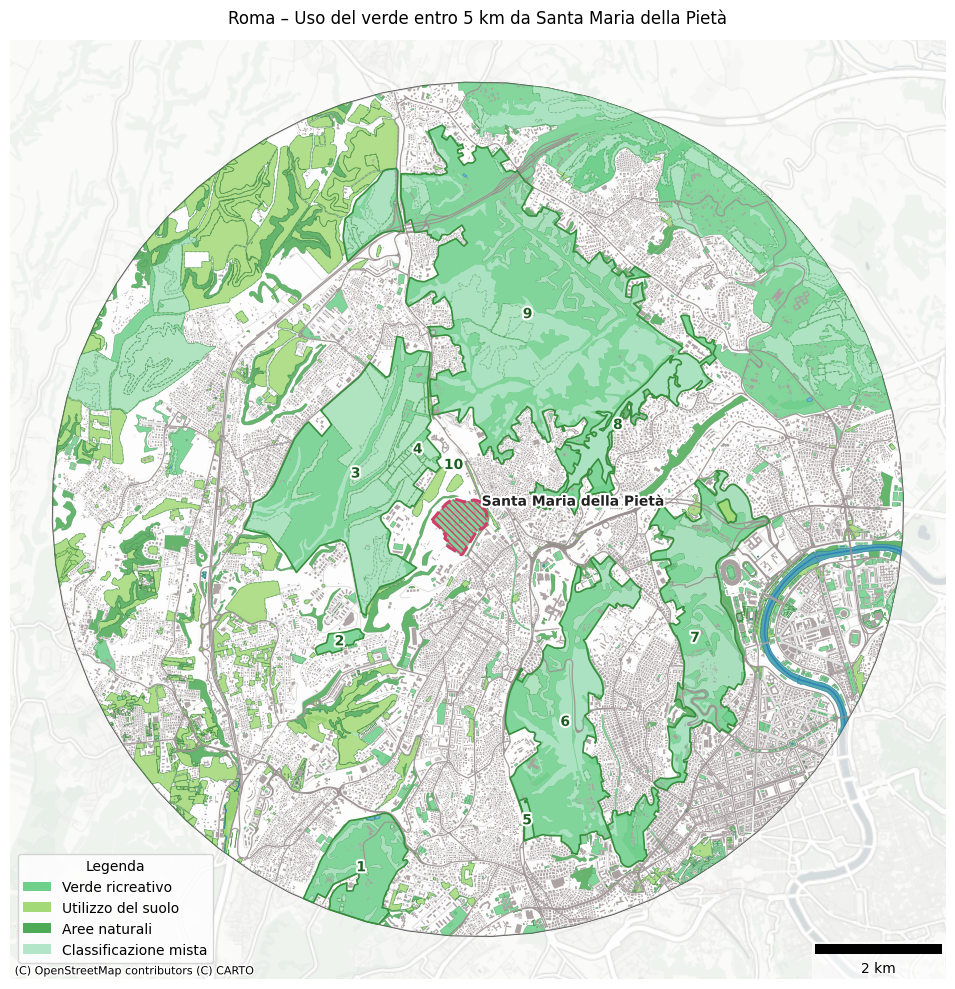

✅ Creato file: mappa_verde_smdp_aree_numerate.png


In [11]:
# ================================================================
# 🗺️ MAPPA COMPLETA (verde corretto) + AREE NUMERATE
# ================================================================
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
from matplotlib.patches import Patch
import matplotlib_scalebar.scalebar as sb
from shapely.geometry import Point
import geopandas as gpd
import contextily as ctx

fig, ax = plt.subplots(figsize=(10,10))

# --- Vuoti dell'AOI (semitrasparenti, per far vedere la basemap) ---
if not non_verde.empty:
    non_verde.plot(
        ax=ax,
        facecolor="white",   # o "#f5f5f5" se vuoi più caldo
        edgecolor="none",
        alpha=0.45,
        zorder=2
    )

# --- AOI e contorno ---
aoi3857.boundary.plot(ax=ax, color="#444444", linewidth=1.0)

# --- Layer "non verde" semitrasparente (per trasparenza basemap) ---
if not non_verde.empty:
    non_verde.plot(
        ax=ax,
        facecolor="white",
        edgecolor="none",
        alpha=0.6,
        zorder=2
    )

# --- Verde base (identico allo stile corretto) ---
verde.plot(ax=ax, color=colors, edgecolor="#4F8F59", linewidth=0.3, alpha=0.85, zorder=5)

# --- Overlap (colore unico) ---
if not verde_overlap.empty:
    verde_overlap.plot(ax=ax, color=COLOR_OVERLAP, edgecolor=None, alpha=0.9, zorder=6)

# --- Basemap ---
if PARAMS["use_basemap"] and HAS_CTX:
    try:
        ctx.add_basemap(
            ax, crs=gdf3857.crs,
            source=ctx.providers.CartoDB.PositronNoLabels,
            zorder=-10
        )
    except Exception:
        pass

# --- Acque ---
if not water_poly3857.empty:
    water_poly3857.plot(ax=ax, facecolor=WATER_FILL, edgecolor=WATER_EDGE,
                        linewidth=0.6, alpha=0.6, zorder=6)
if not water_line3857.empty:
    water_line3857.plot(ax=ax, color=WATER_LINE, linewidth=1.2, alpha=0.9, zorder=7)

# --- Strade ---
if SHOW_ROADS:
    COLOR_MAJOR = "#9C9090"
    COLOR_MINOR = "#bbbbbb"
    if not edges_minor_fused.empty:
        edges_minor_fused.plot(ax=ax, linewidth=0.6, alpha=0.5, color=COLOR_MINOR, zorder=30)
    if not edges_major_fused.empty:
        edges_major_fused.plot(ax=ax, linewidth=0.9, alpha=0.9, color=COLOR_MAJOR, zorder=31)

# --- Landuse ---
if SHOW_LANDUSE_OUTLINES and not landuse3857.empty:
    landuse3857.boundary.plot(ax=ax, linewidth=0.6, linestyle="--",
                              alpha=0.4, color="#2e7d32", zorder=8)
if SHOW_LANDUSE_CENTROIDS and not landuse_centroids3857.empty:
    ax.scatter(landuse_centroids3857.geometry.x, landuse_centroids3857.geometry.y,
               s=8, marker='o', color="#2e7d32", alpha=0.6, zorder=6)

# --- Edifici ---
if not buildings3857.empty:
    buildings3857.plot(ax=ax, color="#aaa0a0", edgecolor=None, linewidth=0.0,
                       alpha=0.95, zorder=50)

# ================================================================
# 🔵 AREE SELEZIONATE NUMERATE (senza alterare il verde)
# ================================================================
if not aree_selezionate.empty:
    # CRS coerente
    if aree_selezionate.crs != verde.crs:
        aree_selezionate = aree_selezionate.to_crs(verde.crs)
    # contorno sottile evidenziato
    aree_selezionate.boundary.plot(ax=ax, color="#388E3C", linewidth=1.2, zorder=120)
    # numeri centrati
    for _, row in aree_selezionate.iterrows():
        centroid = row.geometry.centroid
        ax.text(
            centroid.x, centroid.y, str(row["id_area"]),
            fontsize=10, fontweight="bold", color="#1B5E20",
            ha="center", va="center",
            path_effects=[pe.withStroke(linewidth=3, foreground="white")],
            zorder=130
        )

# ================================================================
# 📍 Marker Santa Maria della Pietà – tratteggio fucsia orizzontale
# ================================================================
from shapely.geometry import Polygon, MultiPolygon
from matplotlib.patches import PathPatch
from shapely.ops import unary_union
from shapely.geometry import Point
import geopandas as gpd
from shapely import geometry
import matplotlib.patheffects as pe
from matplotlib.path import Path
from matplotlib.patches import PathPatch

point_3857 = gpd.GeoDataFrame(geometry=[Point(lon, lat)], crs=4326).to_crs(3857)
p = point_3857.geometry.iloc[0]
gdf_verde_hit = verde[verde.intersects(p)].copy()

if not gdf_verde_hit.empty:
    # Combina tutte le geometrie in un unico poligono (per sicurezza)
    geom_union = unary_union(gdf_verde_hit.geometry)

    # --- contorno fucsia tratteggiato
    gdf_verde_hit.boundary.plot(ax=ax, color="#CE3F6A", linewidth=2.2,
                                linestyle="--", zorder=150)

    # --- tratteggio orizzontale
    if isinstance(geom_union, (Polygon, MultiPolygon)):
        def plot_with_hatch(geom):
            """Crea patch con tratteggio fucsia orizzontale."""
            path = Path.make_compound_path(
                Path(list(geom.exterior.coords)),
                *[Path(list(ring.coords)) for ring in geom.interiors]
            )
            patch = PathPatch(
                path,
                facecolor="none",
                edgecolor="#CE3F6A",
                hatch="\\\\\\\\\\",  # linee orizzontali
                linewidth=0.0,
                alpha=1.0,
                zorder=145
            )
            ax.add_patch(patch)

        if isinstance(geom_union, Polygon):
            plot_with_hatch(geom_union)
        else:  # MultiPolygon
            for g in geom_union.geoms:
                plot_with_hatch(g)

# --- Etichetta del punto
for x, y in zip(point_3857.geometry.x, point_3857.geometry.y):
    ax.text(x + 60, y + 60, "Santa Maria della Pietà",
            fontsize=10, fontweight='bold', color='#222222',
            path_effects=[pe.withStroke(linewidth=3, foreground="white")],
            zorder=151)


# ================================================================
# 📚 Legenda standard verde
# ================================================================
etichetta_italiana = {
    "leisure":  "Verde ricreativo",
    "landuse":  "Utilizzo del suolo",
    "natural":  "Aree naturali",
    "overlap":  "Classificazione mista"
}
handles = [
    Patch(facecolor=palette["leisure"], edgecolor="none", label=etichetta_italiana["leisure"]),
    Patch(facecolor=palette["landuse"], edgecolor="none", label=etichetta_italiana["landuse"]),
    Patch(facecolor=palette["natural"], edgecolor="none", label=etichetta_italiana["natural"]),
    Patch(facecolor=COLOR_OVERLAP, edgecolor="none", label=etichetta_italiana["overlap"])
]
ax.legend(handles=handles, loc="lower left", bbox_to_anchor=(0.001, 0.01), title="Legenda")

# ================================================================
# 📏 Titolo e scalebar
# ================================================================
ax.set_axis_off()
ax.set_title("Roma – Uso del verde entro 5 km da Santa Maria della Pietà", pad=12)
scalebar = sb.ScaleBar(1, units="m", dimension="si-length",
                       location="lower right", box_alpha=0.6)
ax.add_artist(scalebar)

plt.tight_layout()
plt.savefig("mappa_verde_smdp_aree_numerate.png", dpi=200, bbox_inches="tight")
plt.show()

print("✅ Creato file: mappa_verde_smdp_aree_numerate.png")


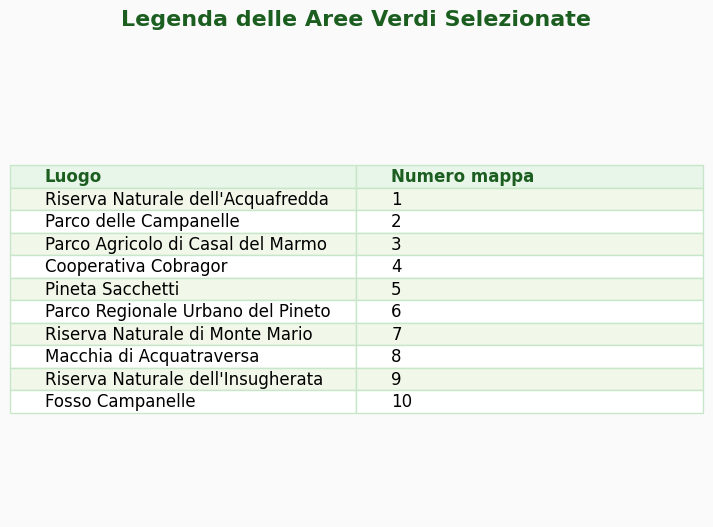

✅ File legenda aggiornato salvato come: legenda_aree_verdi.png


In [12]:
# ================================================================
# 🎨 LEGENDA AREE VERDI SELEZIONATE – versione ridimensionata
# ================================================================
import matplotlib.pyplot as plt
import pandas as pd

# Prepara i dati
aree_sel = aree_selezionate[['name', 'id_area']].copy()
aree_sel = aree_sel.rename(columns={
    'name': 'Luogo',
    'id_area': 'Numero mappa'
}).sort_values(by='Numero mappa').reset_index(drop=True)

# Calcolo altezza dinamica in base al numero di righe
n = len(aree_sel)
fig_height = 0.45 * n + 1.2  # compatta ma leggibile
fig_width = 7                # più largo per nomi lunghi

fig, ax = plt.subplots(figsize=(fig_width, fig_height))
fig.patch.set_facecolor("#fafafa")
ax.set_facecolor("#fafafa")

# Titolo
ax.text(0.5, 1.07, "Legenda delle Aree Verdi Selezionate",
        ha="center", va="bottom", fontsize=16, fontweight="bold", color="#1B5E20",
        transform=ax.transAxes)

# Tabella
table_data = [aree_sel.columns.tolist()] + aree_sel.values.tolist()
table = ax.table(cellText=table_data, cellLoc='left', loc='center')

# Stile tabella
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.1, 1.3)

# Applica colori e bordi
for (row, col), cell in table.get_celld().items():
    if row == 0:
        cell.set_text_props(weight='bold', color='#1B5E20')
        cell.set_facecolor('#E8F5E9')
    else:
        cell.set_facecolor('#FFFFFF' if row % 2 == 0 else '#F1F8E9')
    cell.set_edgecolor('#C8E6C9')

# Allineamento colonna numerica a destra
for row in range(1, n + 1):
    table[row, 1]._loc = 'right'

# Layout
ax.axis("off")
plt.subplots_adjust(left=0.05, right=0.95, top=0.85, bottom=0.05)

# Salvataggio PNG ad alta risoluzione
plt.savefig("legenda_aree_verdi.png", dpi=300, bbox_inches="tight", facecolor=fig.get_facecolor())
plt.show()

print("✅ File legenda aggiornato salvato come: legenda_aree_verdi.png")
